训练代码

In [10]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from network import resnet
from utils.earlystop import EarlyStopping


画图函数，用于画训练过程中的loss和acc

In [11]:
def plt_line(line_list, save_path, show=True):
    plt.ion()
    plt.figure(figsize=(20, 5))
    count = len(line_list)
    for i in range(count):
        # 如果没有给数据，则显示默认值
        line_list[i]['color'] = line_list[i]['color'] if 'color' in line_list[i].keys() else 'deepskyblue'
        line_list[i]['linestyle'] = line_list[i]['linestyle'] if 'linestyle' in line_list[i].keys() else '-'
        line_list[i]['marker'] = line_list[i]['marker'] if 'marker' in line_list[i].keys() else 'o'
        line_list[i]['markersize'] = line_list[i]['markersize'] if 'markersize' in line_list[i].keys() else 2
        line_list[i]['markerfacecolor'] = line_list[i]['markerfacecolor'] if 'markerfacecolor' in line_list[i].keys() else 'blue'
        line_list[i]['markeredgecolor'] = line_list[i]['markeredgecolor'] if 'markeredgecolor' in line_list[i].keys() else 'green'
        line_list[i]['markeredgewidth'] = line_list[i]['markeredgewidth'] if 'markeredgewidth' in line_list[i].keys() else 1

        # 绘制图形
        plt.plot(line_list[i]['xdata'], line_list[i]['ydata'], color=line_list[i]['color'],
                 linestyle=line_list[i]['linestyle'],
                 linewidth=1, marker=line_list[i]['marker'], markersize=line_list[i]['markersize'],
                 markerfacecolor=line_list[i]['markerfacecolor'], markeredgecolor=line_list[i]['markeredgecolor'],
                 markeredgewidth=line_list[i]['markeredgewidth'], label=line_list[i]['label'])
    # plt.grid()
    # plt.ylim(0, 1.1)
    plt.xticks(np.arange(min(line_list[0]['xdata']), max(line_list[0]['xdata']) + 1, 1))  # 设置刻度为从最小值到最大值
    plt.legend()
    plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()


调整学习率函数，每次调整为原来的1/10，直到小于最小学习率，在验证集准确率连续5次没有提升时调用

In [12]:
def adjust_learning_rate(optimizer, min_lr=1e-6):
    for param_group in optimizer.param_groups:
        param_group['lr'] /= 10.
        if param_group['lr'] < min_lr:
            return False
    return True

保存模型函数

In [13]:
def save_networks(model, epoch, opt):
    os.makedirs(opt.save_path, exist_ok=True)
    save_filename = 'model_epoch_%s.pth' % epoch
    save_path = os.path.join(opt.save_path, save_filename)
    # serialize model and optimizer to dict
    state_dict = {
        'model': model.state_dict(),
    }
    torch.save(state_dict, save_path)


测试函数，用于测试模型在验证集上的准确率

In [14]:
def validate(model, dataroot, device):
    model.eval()
    correct = 0
    loss_t = 0.0
    with torch.no_grad():
        for img, label in dataloader:
            img = img.to(device)
            label = label.to(device)
            pred = model(img).sigmoid()

            loss = loss_fn(pred, label)
            loss_t += loss.item()
            correct += (pred.argmax(-1) == label).type(torch.float).sum().item()

    correct /= len(dataloader.dataset)
    loss_t /= len(dataloader)
    print(f'Accuracy: {correct}')
    return correct, loss_t


参数设置

In [17]:
args = argparse.ArgumentParser()
args.add_argument('--lr', type=float, default=0.01)
args.add_argument('--batch_size', type=int, default=32)
args.add_argument('--num_workers', type=int, default=4)
args.add_argument('--epochs', type=int, default=1000)
args.add_argument('--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu')
args.add_argument('--earlystop_epoch', type=int, default=5)
args.add_argument('--loss_freq', type=int, default=50)
args.add_argument('--save_latest_freq', type=int, default=1000)
args.add_argument('--name', type=str, default='monkeypoxskin')
args.add_argument('--save_path', type=str, default='checkpoints')
args.add_argument('--save_epoch_freq', type=int, default=5)
args.add_argument('--dataroot', type=str, default='H:/机器学习/monkeypoxskin_code/monkeypoxskin_code/data/DataSet_5s_single_image')

opt = args.parse_args(args=[])


获取数据集、模型、损失函数、优化器、定义早停法

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),#随机水平翻转
    transforms.RandomRotation(30),#随机旋转
    transforms.ToTensor(),   # 转为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=os.path.join(opt.dataroot, 'train'), transform=transform)
dataloader = DataLoader(dataset, batch_size=opt.batch_size, shuffle=True, num_workers=opt.num_workers)
model = resnet.resnet34(pretrained=True)
model.fc = nn.Linear(512, 3)
model = model.to(opt.device)

loss_fn = nn.CrossEntropyLoss().to(opt.device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr)

early_stopping = EarlyStopping(patience=opt.earlystop_epoch, delta=-0.001, verbose=True)


保存训练过程和测试过程中的损失和准确率

In [19]:
loss_train_list = []
acc_train_list = []
loss_val_list = []
acc_val_list = []
total_step = 0

开始训练

Epoch [0/1000] Batch [0/36] Loss: 1.5208954811096191
saving the latest model monkeypoxskin (epoch 0)
Accuracy: 0.5851063829787234
(Val @ epoch 0) acc: 0.5851063829787234;


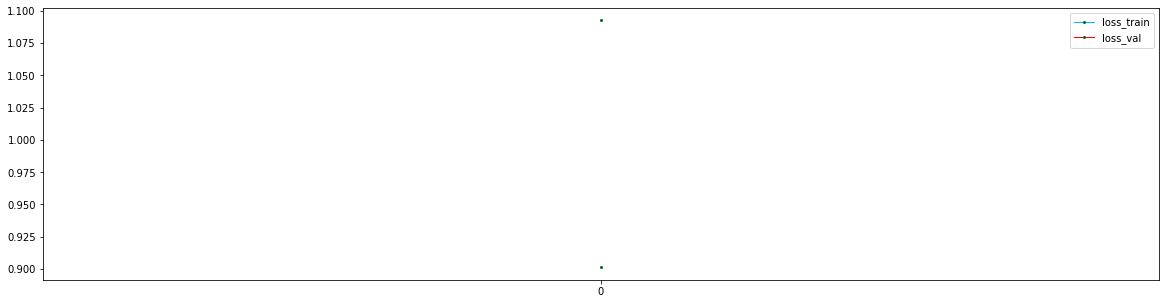

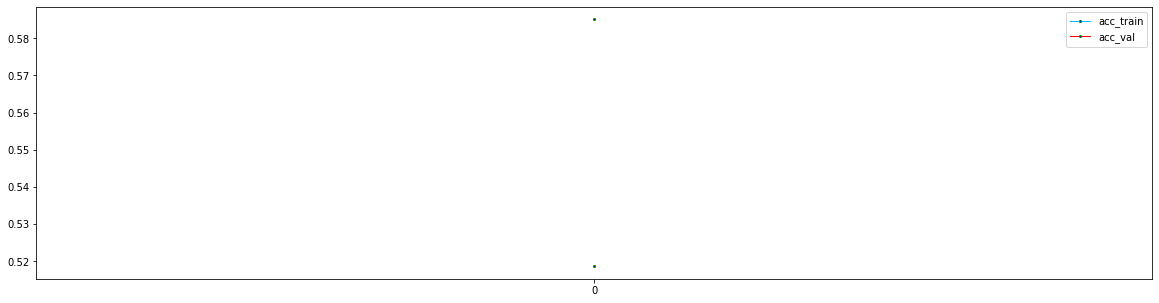

saving the model at the end of epoch 0, iters 36
Validation accuracy increased (-inf --> 0.585106).  Saving model ...
Epoch [1/1000] Batch [14/36] Loss: 0.6038877964019775
Accuracy: 0.6888297872340425
(Val @ epoch 1) acc: 0.6888297872340425;


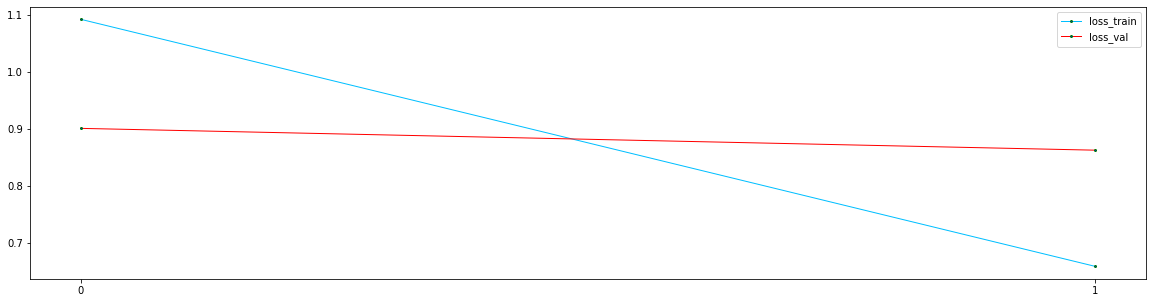

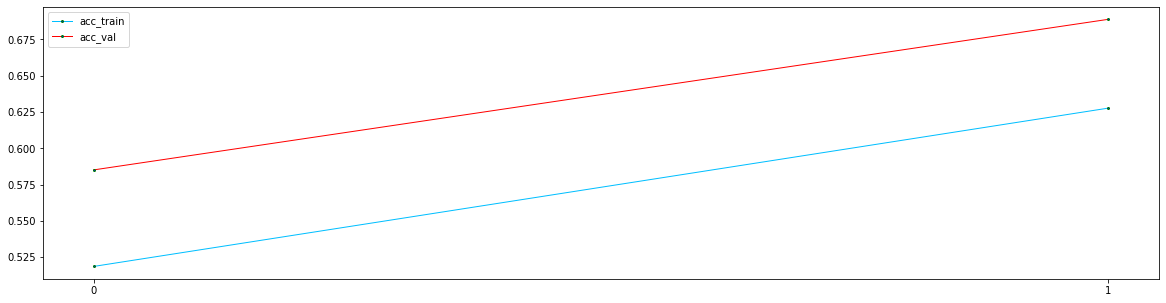

Validation accuracy increased (0.585106 --> 0.688830).  Saving model ...
Epoch [2/1000] Batch [28/36] Loss: 0.9657511115074158
Accuracy: 0.6710992907801419
(Val @ epoch 2) acc: 0.6710992907801419;


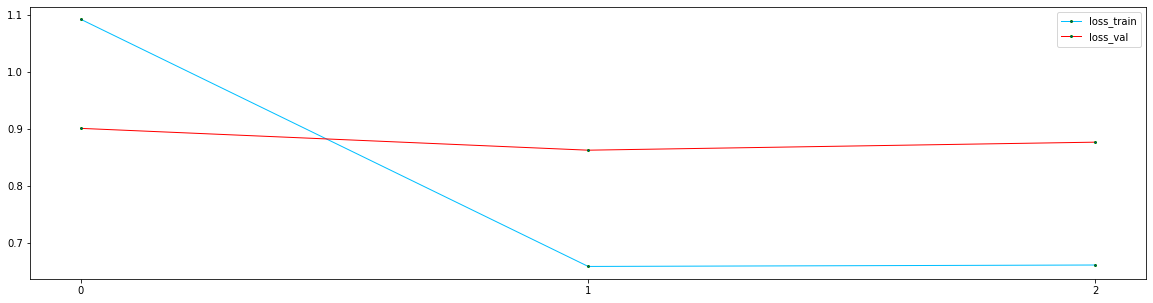

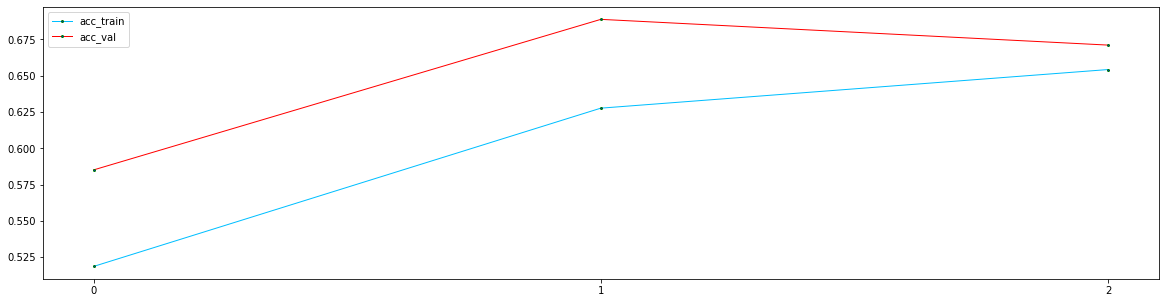

EarlyStopping counter: 1 out of 5
Accuracy: 0.6870567375886525
(Val @ epoch 3) acc: 0.6870567375886525;


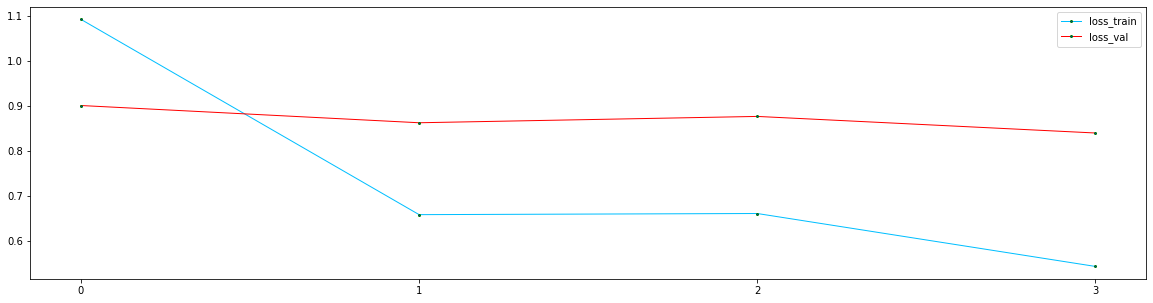

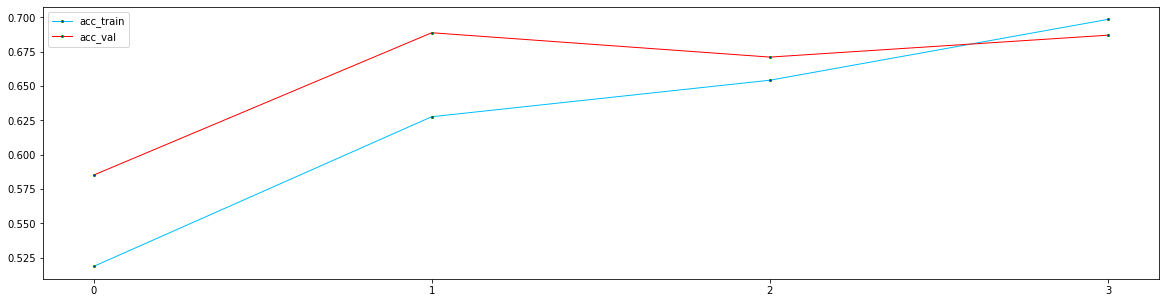

EarlyStopping counter: 2 out of 5
Epoch [4/1000] Batch [6/36] Loss: 0.4454379379749298
Accuracy: 0.7296099290780141
(Val @ epoch 4) acc: 0.7296099290780141;


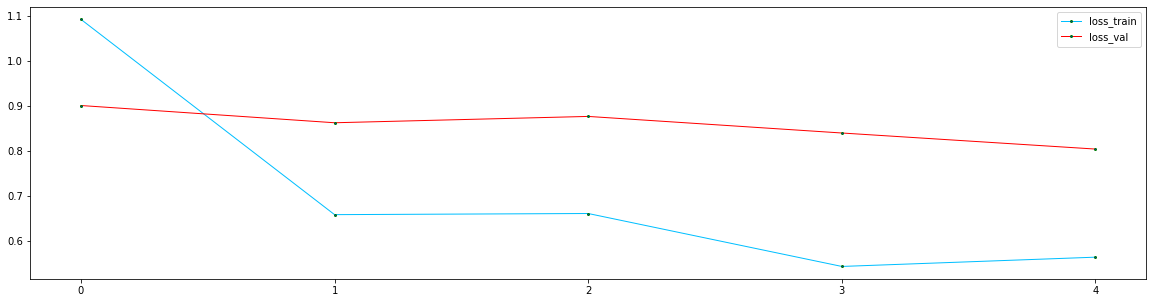

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002616C307798>
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "D:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


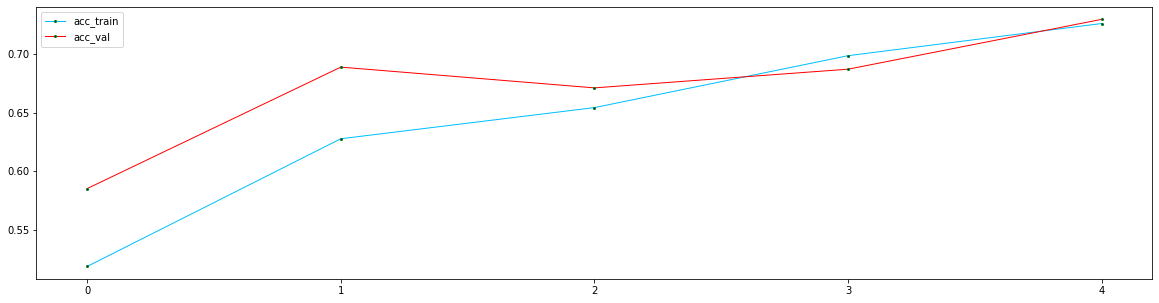

Validation accuracy increased (0.688830 --> 0.729610).  Saving model ...
Epoch [5/1000] Batch [20/36] Loss: 0.5087583065032959
Accuracy: 0.6125886524822695
(Val @ epoch 5) acc: 0.6125886524822695;


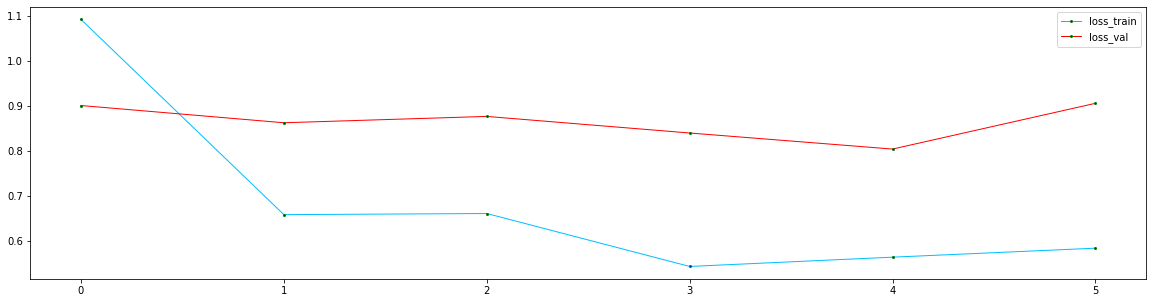

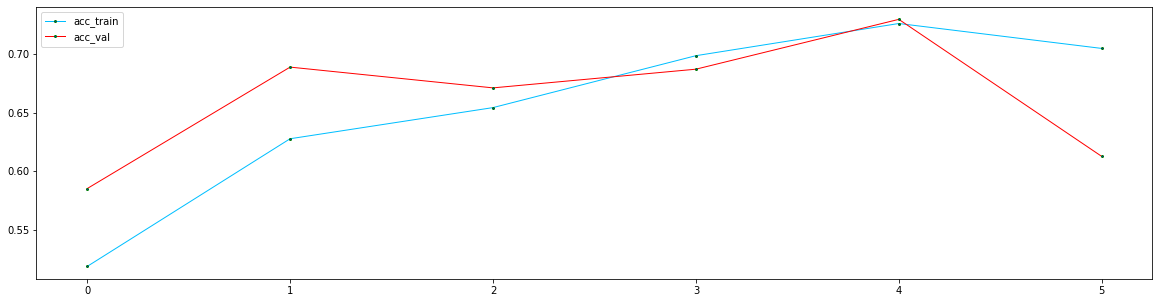

saving the model at the end of epoch 5, iters 216
EarlyStopping counter: 1 out of 5
Epoch [6/1000] Batch [34/36] Loss: 0.4475550949573517
Accuracy: 0.6285460992907801
(Val @ epoch 6) acc: 0.6285460992907801;


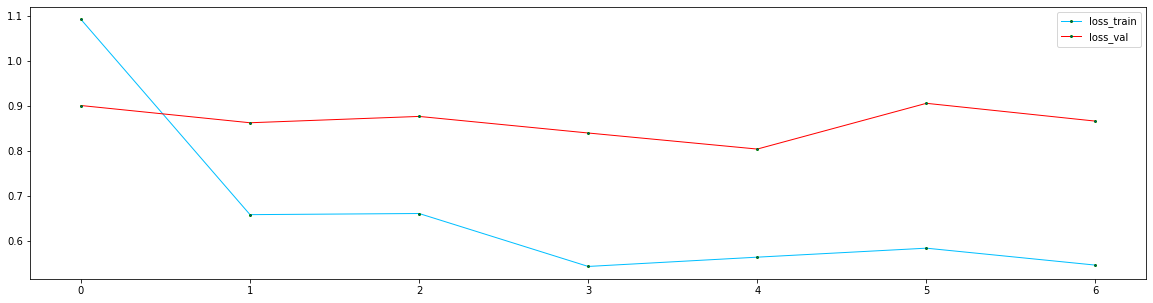

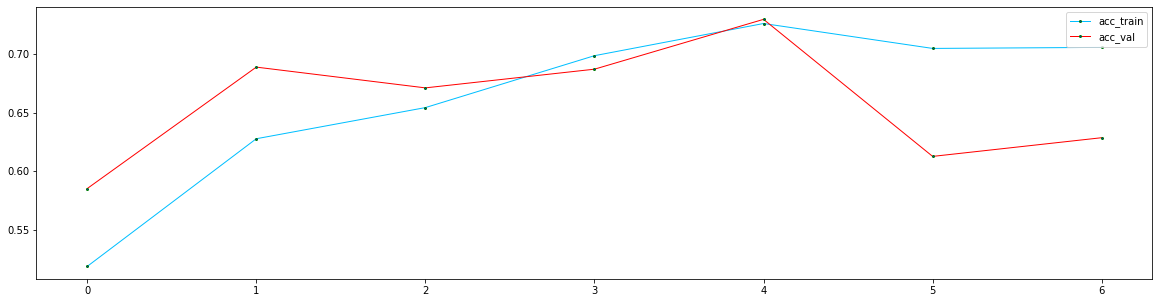

EarlyStopping counter: 2 out of 5
Accuracy: 0.5682624113475178
(Val @ epoch 7) acc: 0.5682624113475178;


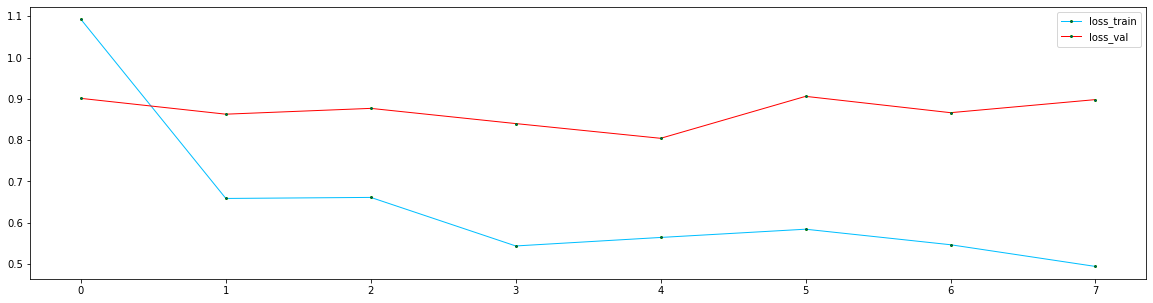

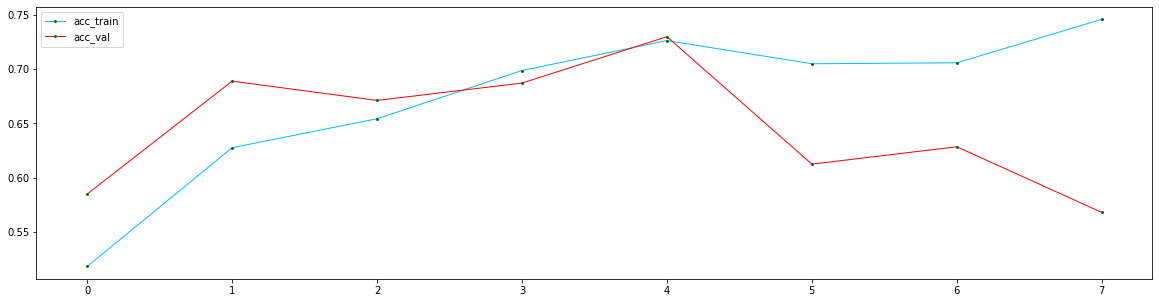

EarlyStopping counter: 3 out of 5
Epoch [8/1000] Batch [12/36] Loss: 0.532896101474762
Accuracy: 0.7429078014184397
(Val @ epoch 8) acc: 0.7429078014184397;


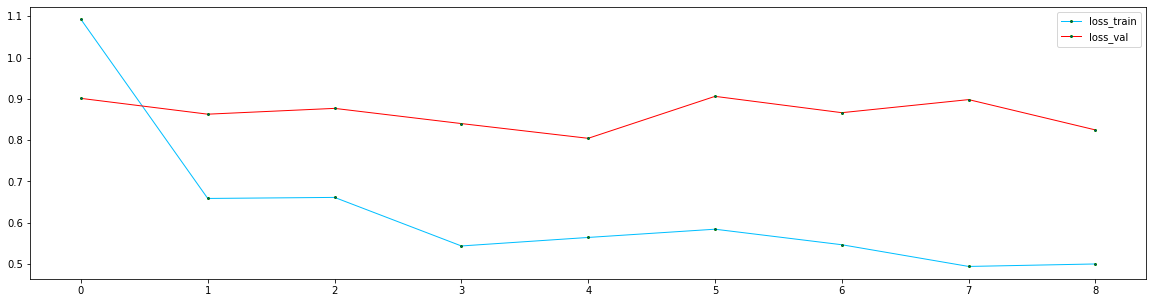

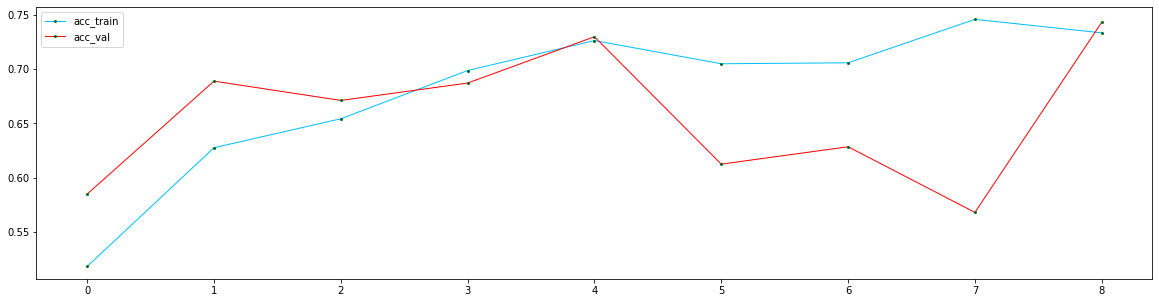

Validation accuracy increased (0.729610 --> 0.742908).  Saving model ...
Epoch [9/1000] Batch [26/36] Loss: 0.37483641505241394
Accuracy: 0.7101063829787234
(Val @ epoch 9) acc: 0.7101063829787234;


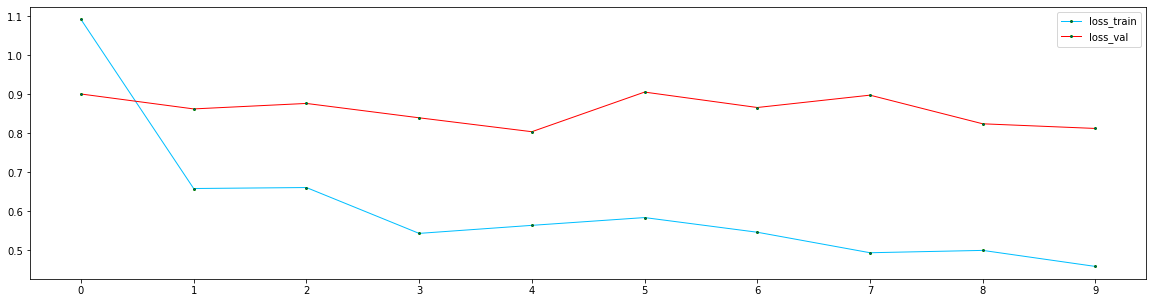

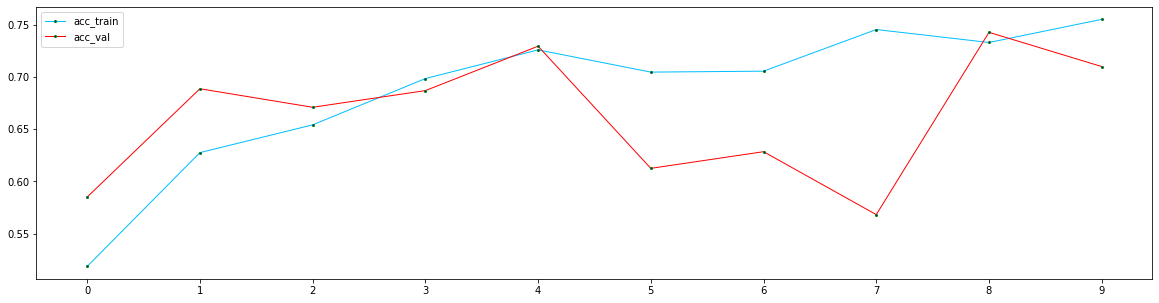

EarlyStopping counter: 1 out of 5
Accuracy: 0.7597517730496454
(Val @ epoch 10) acc: 0.7597517730496454;


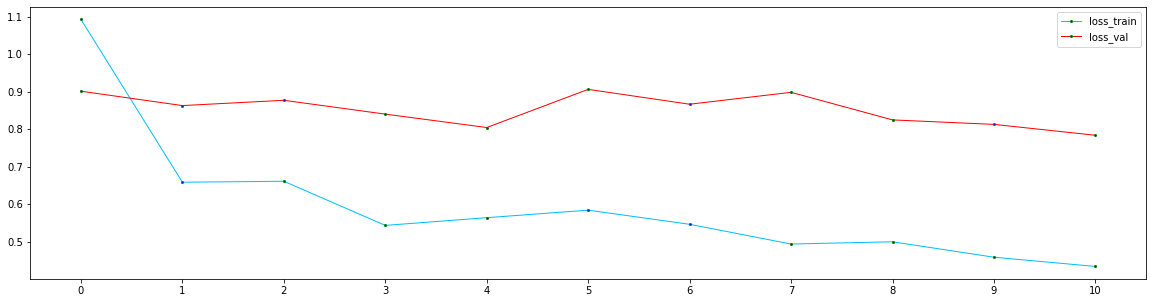

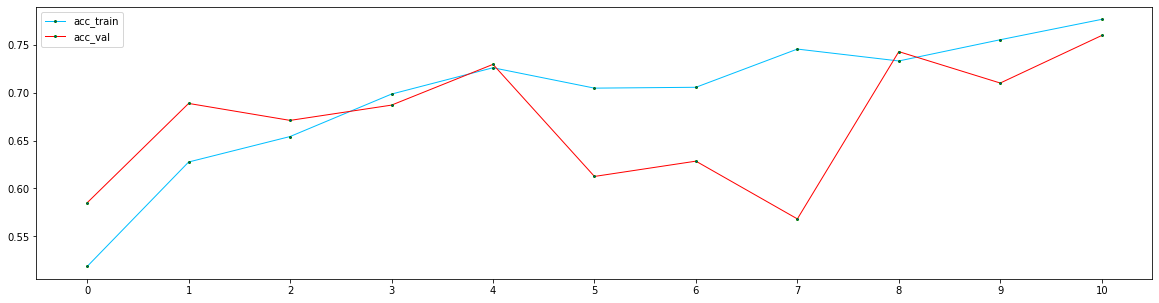

saving the model at the end of epoch 10, iters 396
Validation accuracy increased (0.742908 --> 0.759752).  Saving model ...
Epoch [11/1000] Batch [4/36] Loss: 0.467315137386322
Accuracy: 0.7774822695035462
(Val @ epoch 11) acc: 0.7774822695035462;


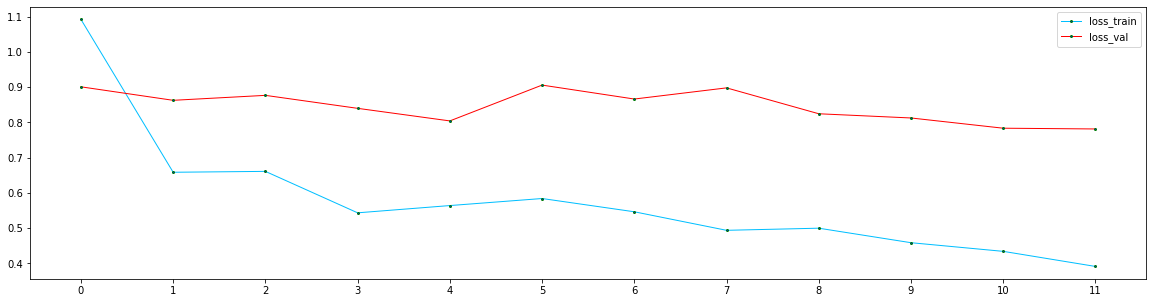

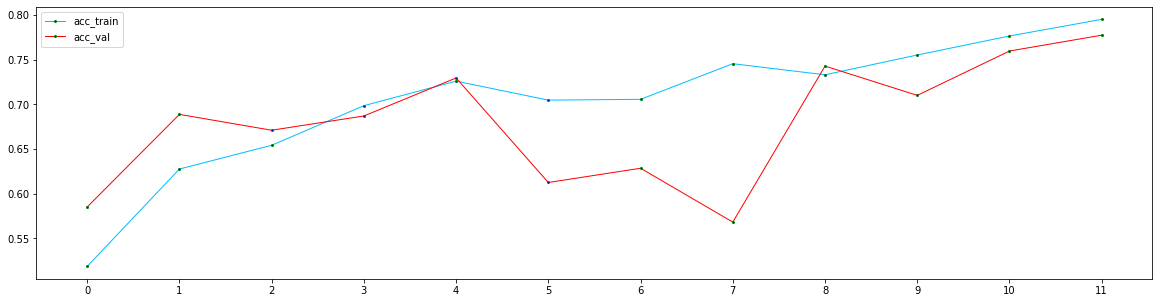

Validation accuracy increased (0.759752 --> 0.777482).  Saving model ...
Epoch [12/1000] Batch [18/36] Loss: 0.5225849151611328
Accuracy: 0.7074468085106383
(Val @ epoch 12) acc: 0.7074468085106383;


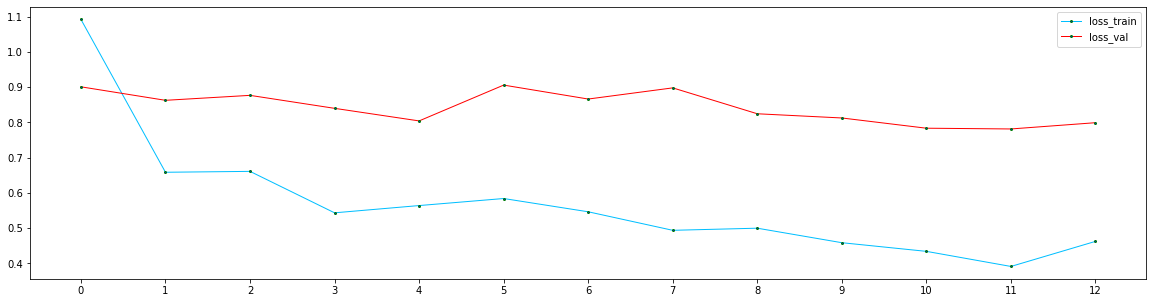

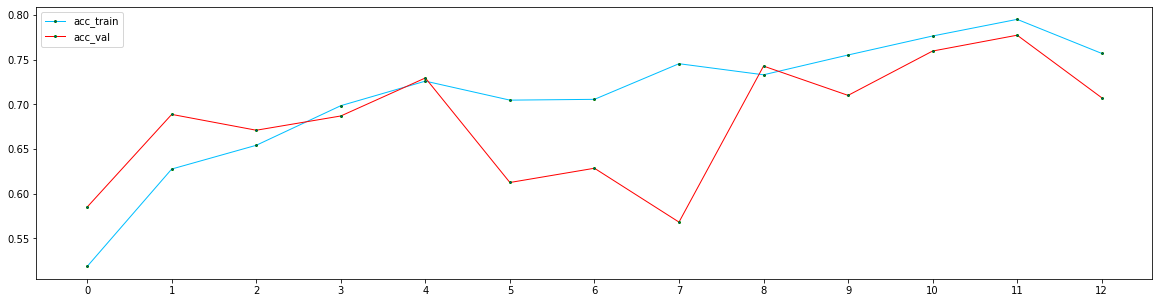

EarlyStopping counter: 1 out of 5
Epoch [13/1000] Batch [32/36] Loss: 0.4330628216266632
Accuracy: 0.7322695035460993
(Val @ epoch 13) acc: 0.7322695035460993;


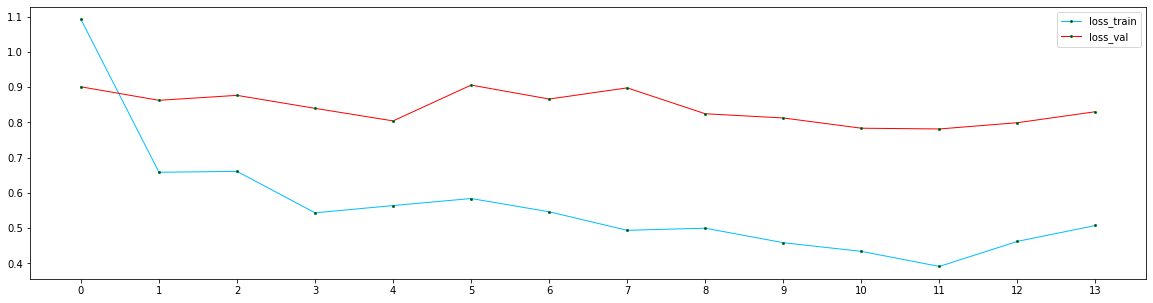

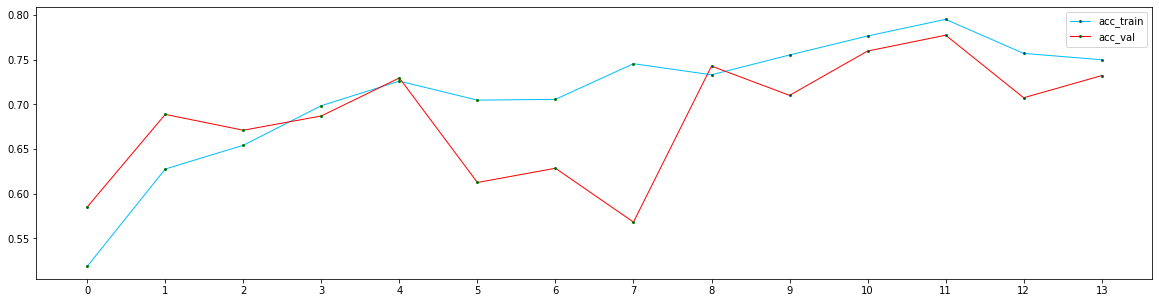

EarlyStopping counter: 2 out of 5


KeyboardInterrupt: 

In [20]:
for epoch in range(opt.epochs):
    model.train()
    loss_train = 0.0
    acc_train = 0.0
    for i, (img, label) in enumerate(dataloader):
        img = img.to(opt.device)
        label = label.to(opt.device)

        pred = model(img)
        loss = loss_fn(pred, label)
        loss_train += loss.item()
        pred = model(img).sigmoid()
        acc_train += (pred.argmax(-1) == label).type(torch.float).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if total_step % opt.loss_freq == 0:
            print(f'Epoch [{epoch}/{opt.epochs}] Batch [{i}/{len(dataloader)}] Loss: {loss.item()}')

        if total_step % opt.save_latest_freq == 0:
            print('saving the latest model %s (epoch %d)' %(opt.name, epoch))
            save_networks(model, 'latest', opt)

        total_step += 1
    acc_train = acc_train / len(dataloader.dataset)
    val_acc, val_loss = validate(model, os.path.join(opt.dataroot, 'val'), opt.device)

    print("(Val @ epoch {}) acc: {};".format(epoch, val_acc))
    loss_train_list.append(loss_train/ len(dataloader))
    acc_train_list.append(acc_train)
    loss_val_list.append(val_loss)
    acc_val_list.append(val_acc)

    plt_line([
        {'xdata': range(len(loss_train_list)), 'ydata': loss_train_list, 'label': 'loss_train'},
        {'xdata': range(len(loss_val_list)), 'ydata': loss_val_list, 'label': 'loss_val', 'color': 'red'}
    ], 'result/loss.png', show=True)

    plt_line([
        {'xdata': range(len(acc_train_list)), 'ydata': acc_train_list, 'label': 'acc_train'},
        {'xdata': range(len(acc_val_list)), 'ydata': acc_val_list, 'label': 'acc_val', 'color': 'red'}
    ], 'result/acc.png', show=True)


    if epoch % opt.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_step))
        save_networks(model, 'latest', opt)
        # save_networks(model, epoch, opt)
    early_stopping(val_acc, model)
    if early_stopping.early_stop:
        cont_train = adjust_learning_rate(optimizer)
        if cont_train:
            print("Learning rate dropped by 10, continue training...")
            early_stopping = EarlyStopping(patience=opt.earlystop_epoch, delta=-0.002, verbose=True)
        else:
            print("Early stopping.")
            break
    model.train()

loss_train_list = np.array(loss_train_list)
acc_train_list = np.array(acc_train_list)
loss_val_list = np.array(loss_val_list)
acc_val_list = np.array(acc_val_list)
np.save('result/loss_train.npy', loss_train_list)
np.save('result/acc_train.npy', acc_train_list)
np.save('result/loss_val.npy', loss_val_list)
np.save('result/acc_val.npy', acc_val_list)